## Proximity analysis of IPF sample

This notebook is largely based on the Squidpy tutorial (https://squidpy.readthedocs.io/en/stable/notebooks/tutorials/tutorial_xenium.html) for analyzing Xenium data. Please make sure that you have `squidpy >= 1.5.0` installed.

This notebook produces figures `spatial_scatter.pdf` that shows the Xenium slide annotated with various markers and `co_occurrence_confidence.pdf` that shows the probability ratio of ARG1+ with IL6+ vs IL6-. The confidence intervals are produced by performing 50% random subsampling of the entire sample 5 times.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import scanpy as sc
import squidpy as sq

import os

RANDOM_STATE = 0

### Note: this tutorial requires an AnnData object containing the Xenium data. To run this tutorial on your own data, replace the variable `adata_xenium_filename` with the path to the AnnData object you would like to use.

In [2]:
data_dir = '/data/yosef2/scratch/users/charleschien101/ucsf/xenium/IPF_samples/IPF_23865_slide_0027833'
adata_xenium_filename = f'{data_dir}/anndata_xenium_sample_2.h5ad'
figures_dir = 'figures'

In [3]:
adata = sc.read_h5ad(adata_xenium_filename)
adata

AnnData object with n_obs × n_vars = 344543 × 430
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'cell_area', 'seurat_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'markers'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'markers_colors'
    obsm: 'X_pca', 'X_umap', 'spatial'
    layers: 'counts', 'log_norm_counts', 'norm_counts'

In [4]:
adata.obs['markers'].value_counts()

markers
other           318881
IL6- CTHRC1+     22124
ARG1+             2045
IL6+ CTHRC1+      1493
Name: count, dtype: int64

/home/eecs/charleschien101/anaconda3/envs/seuratv5/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


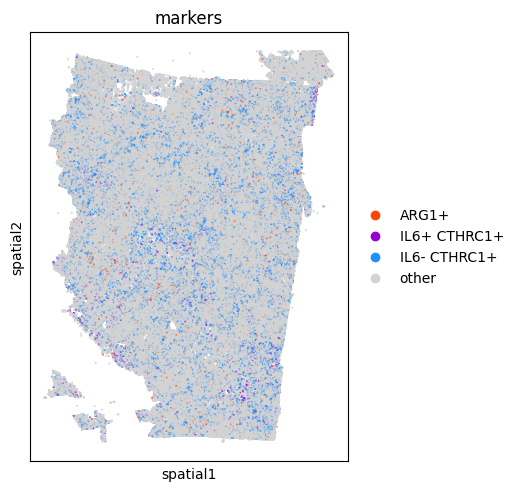

In [5]:
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    shape=None,
    color='markers',
    palette=ListedColormap(colors=['orangered', 'darkviolet', 'dodgerblue', 'lightgray']),
    save=f'spatial_scatter.pdf'
)

In [6]:
adata

AnnData object with n_obs × n_vars = 344543 × 430
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'cell_area', 'seurat_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'markers'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'markers_colors'
    obsm: 'X_pca', 'X_umap', 'spatial'
    layers: 'counts', 'log_norm_counts', 'norm_counts'

In [7]:
num_subsets = 5
adata_subsets = [sc.pp.subsample(adata, fraction=0.5, copy=True, random_state=i) for i in range(num_subsets)]

/home/eecs/charleschien101/anaconda3/envs/seuratv5/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/home/eecs/charleschien101/anaconda3/envs/seuratv5/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/home/eecs/charleschien101/anaconda3/envs/seuratv5/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/home/eecs/charleschien101/anaconda3/envs/seuratv5/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/home/eecs/charleschien101/anaconda3/envs/seuratv5/lib/python3.11/site-packages/

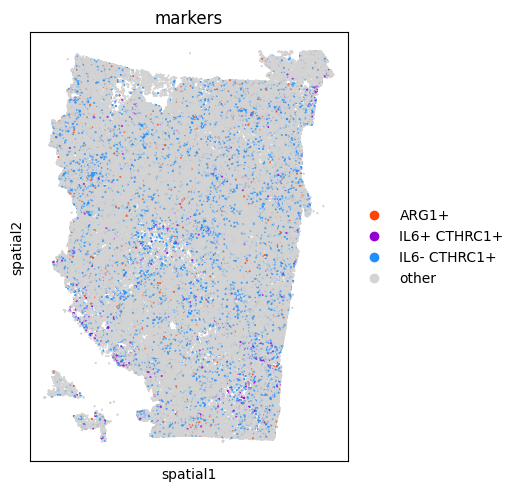

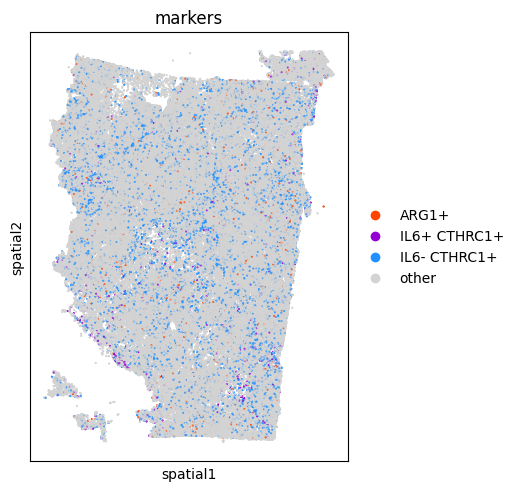

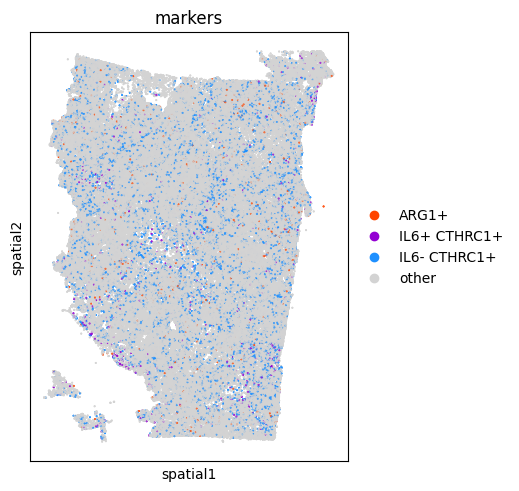

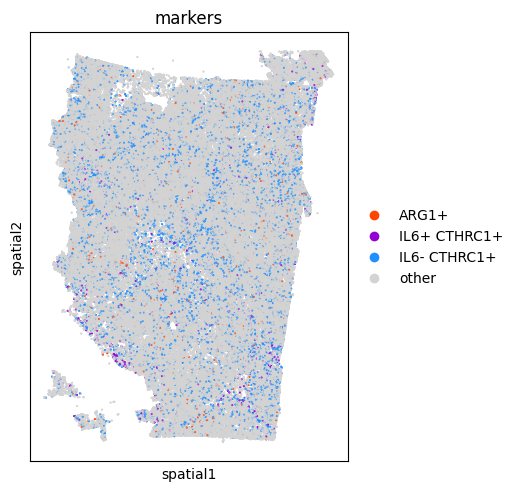

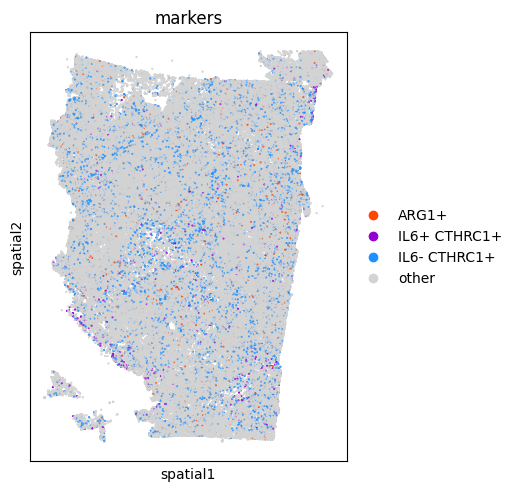

In [8]:
for i in range(num_subsets):
    sq.pl.spatial_scatter(
        adata_subsets[i],
        library_id="spatial",
        shape=None,
        color='markers',
        palette=ListedColormap(colors=['orangered', 'darkviolet', 'dodgerblue', 'lightgray']),
    )

  0%|          | 0/3655 [00:00<?, ?/s]

  0%|          | 0/3655 [00:00<?, ?/s]

  0%|          | 0/3655 [00:00<?, ?/s]

  0%|          | 0/3655 [00:00<?, ?/s]

  0%|          | 0/3655 [00:00<?, ?/s]

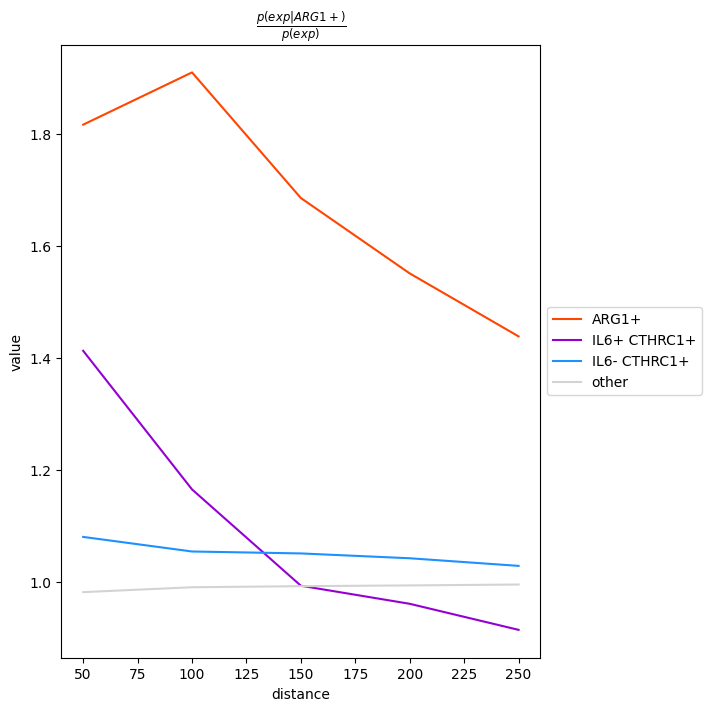

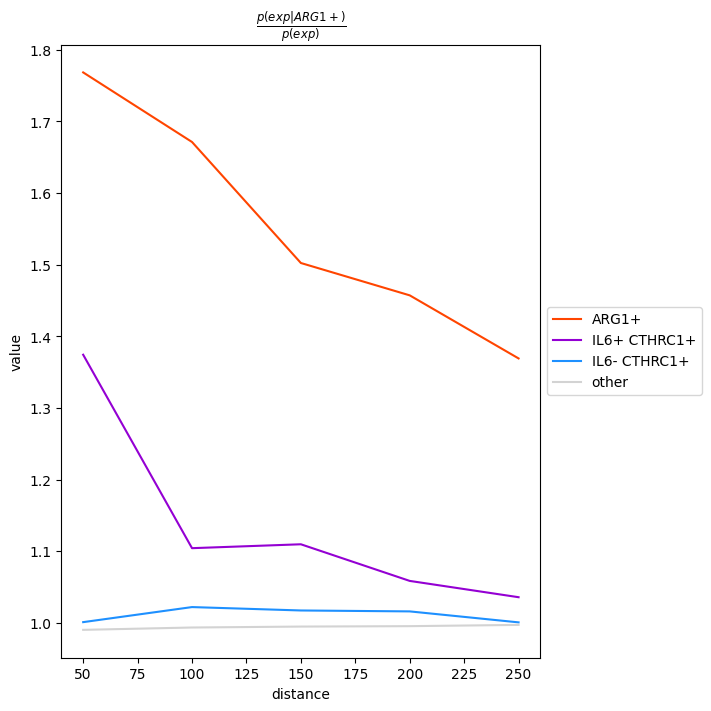

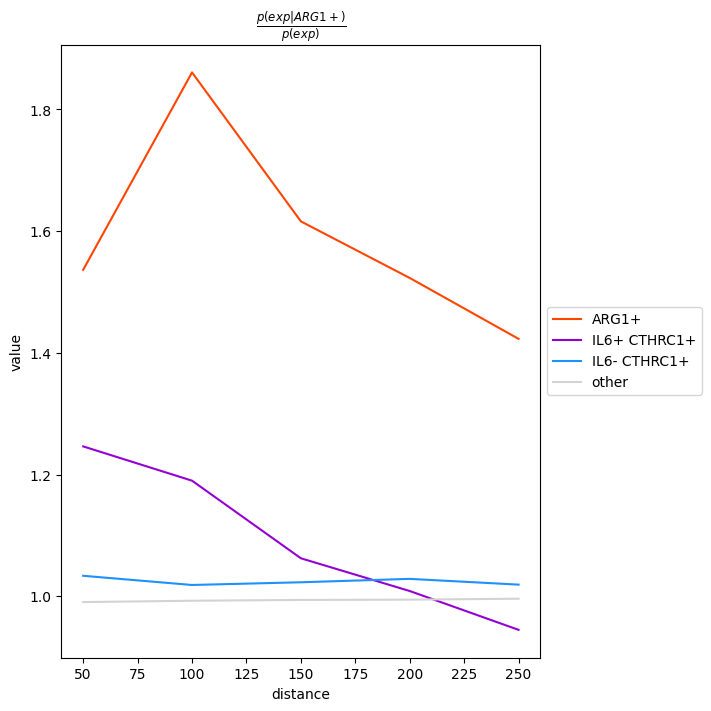

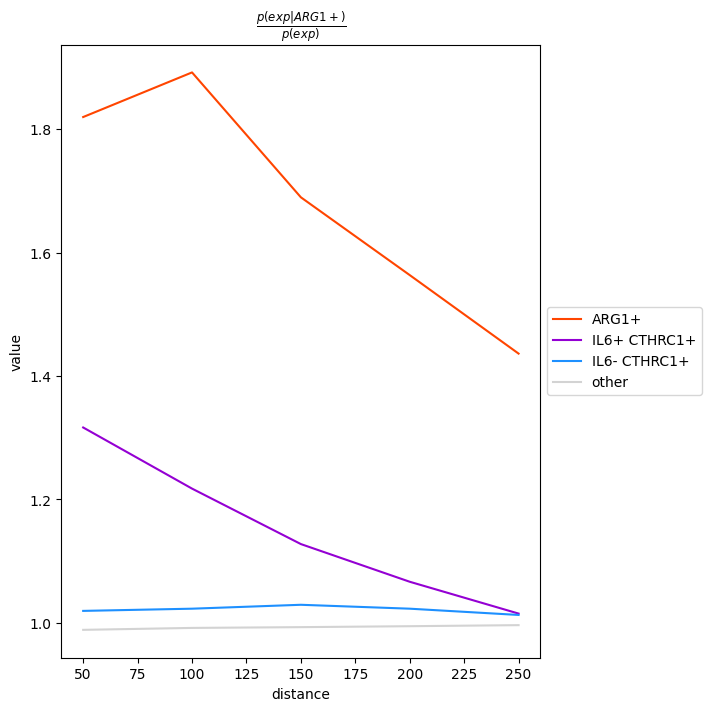

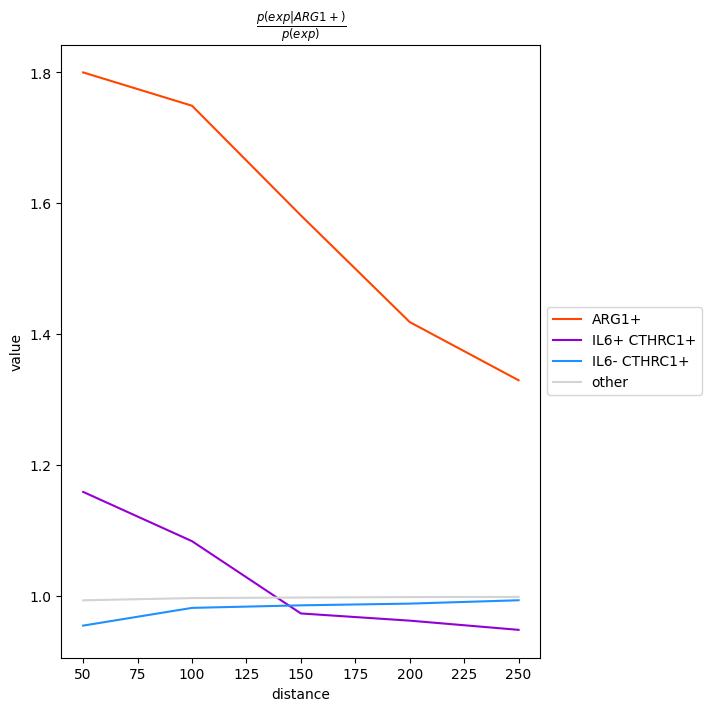

In [9]:
for adata_subset in adata_subsets:
    sq.gr.co_occurrence(adata_subset, cluster_key='markers', interval=np.arange(0, 300, 50))
    sq.pl.co_occurrence(
        adata_subset,
        cluster_key="markers",
        clusters='ARG1+',
        figsize=(7, 7),
    )

### Note: this cell allows you to save the co-occurrence probability ratios so that you can retrieve them directly without having to compute them again

In [10]:
if not os.path.exists('co_occurrences'):
    os.makedirs('co_occurrences')

for i in range(5):
    np.savetxt(f'co_occurrences/arg1+_occ_{i}.txt', adata_subsets[i].uns['markers_co_occurrence']['occ'][0])

In [11]:
occ_arr = []
for i in range(5):
    occ_arr.append(np.loadtxt(f'co_occurrences/arg1+_occ_{i}.txt'))
occ_arr = np.array(occ_arr)
occ_arr

array([[[1.81615925, 1.90936685, 1.68522549, 1.55073595, 1.43837392],
        [1.41265059, 1.16531169, 0.99347144, 0.96122956, 0.91474438],
        [1.08056188, 1.05456042, 1.05110025, 1.04248619, 1.02888954],
        [0.98202664, 0.99076289, 0.99267864, 0.99403214, 0.99561548]],

       [[1.76847351, 1.67133689, 1.50242209, 1.45726311, 1.36920857],
        [1.37438297, 1.10433507, 1.10977507, 1.05863512, 1.03588068],
        [1.00108576, 1.02211201, 1.01736784, 1.01608038, 1.00076544],
        [0.99032015, 0.99358517, 0.9948979 , 0.99547613, 0.99721777]],

       [[1.53649819, 1.86084342, 1.6160903 , 1.52309442, 1.42301452],
        [1.24634218, 1.19002593, 1.06251442, 1.00871253, 0.94490492],
        [1.03374302, 1.01863432, 1.0230788 , 1.02867532, 1.01921248],
        [0.99055481, 0.99271983, 0.99405599, 0.99452549, 0.99607253]],

       [[1.81993413, 1.89225411, 1.68981814, 1.56372023, 1.43648219],
        [1.31671047, 1.21764159, 1.12773824, 1.06665576, 1.01507092],
        [1.019

In [12]:
avg_occ_arr = sum(occ_arr) / len(occ_arr)
avg_occ_arr

array([[1.74822249, 1.81658297, 1.61501195, 1.50265775, 1.39931717],
       [1.30179524, 1.15217307, 1.05332172, 1.01146991, 0.9717303 ],
       [1.01787064, 1.01998606, 1.02127892, 1.01967641, 1.01099691],
       [0.9889583 , 0.99310604, 0.99443023, 0.99535656, 0.99672116]])

In [13]:
interval_arr = np.arange(0, 300, 50)

In [14]:
categories = ['ARG1+', 'IL6+ CTHRC1+', 'IL6- CTHRC1+', 'others']

In [15]:
occ_dfs = []
for i in range(5):
    out = occ_arr[i]
    cluster_key = 'markers'
    interval = interval_arr[1:]
    df = pd.DataFrame(out.T, columns=categories).melt(var_name=cluster_key, value_name="probability")
    df["distance"] = np.tile(interval, len(categories))
    occ_dfs.append(df)

In [16]:
out = avg_occ_arr
cluster_key = 'markers'
interval = interval_arr[1:]
avg_df = pd.DataFrame(out.T, columns=categories).melt(var_name=cluster_key, value_name="probability")
avg_df["distance"] = np.tile(interval, len(categories))
avg_df

,markers,probability,distance
0,ARG1+,1.748222,50
1,ARG1+,1.816583,100
2,ARG1+,1.615012,150
3,ARG1+,1.502658,200
4,ARG1+,1.399317,250
5,IL6+ CTHRC1+,1.301795,50
6,IL6+ CTHRC1+,1.152173,100
7,IL6+ CTHRC1+,1.053322,150
8,IL6+ CTHRC1+,1.011470,200
9,IL6+ CTHRC1+,0.971730,250


In [17]:
max_df = occ_dfs[0].copy()
for i in range(1, 5):
    max_df['probability'] = np.maximum(max_df['probability'], occ_dfs[i]['probability'])
max_df

,markers,probability,distance
0,ARG1+,1.819934,50
1,ARG1+,1.909367,100
2,ARG1+,1.689818,150
3,ARG1+,1.563720,200
4,ARG1+,1.438374,250
5,IL6+ CTHRC1+,1.412651,50
6,IL6+ CTHRC1+,1.217642,100
7,IL6+ CTHRC1+,1.127738,150
8,IL6+ CTHRC1+,1.066656,200
9,IL6+ CTHRC1+,1.035881,250


In [18]:
min_df = occ_dfs[0].copy()
for i in range(1, 5):
    min_df['probability'] = np.minimum(min_df['probability'], occ_dfs[i]['probability'])
min_df

,markers,probability,distance
0,ARG1+,1.536498,50
1,ARG1+,1.671337,100
2,ARG1+,1.502422,150
3,ARG1+,1.418475,200
4,ARG1+,1.329507,250
5,IL6+ CTHRC1+,1.158890,50
6,IL6+ CTHRC1+,1.083551,100
7,IL6+ CTHRC1+,0.973109,150
8,IL6+ CTHRC1+,0.961230,200
9,IL6+ CTHRC1+,0.914744,250


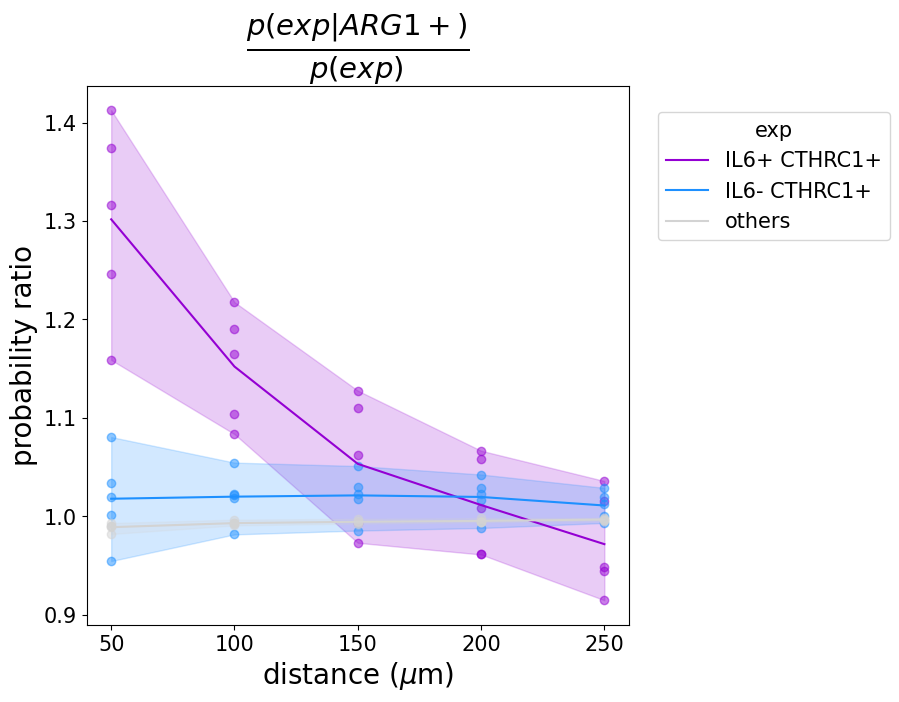

In [19]:
colors = ['orangered', 'darkviolet', 'dodgerblue', 'lightgray']
fig, ax = plt.subplots(figsize=(7, 7))
for marker, color in zip(categories, colors):

    if marker == 'ARG1+':
        continue
    # Plot average co_occurrence
    filtered_avg_df = avg_df[avg_df['markers'] == marker]
    ax.plot(filtered_avg_df['distance'], filtered_avg_df['probability'], color=color, label=marker)

    # Plot all co_occurrence samples
    for i in range(5):
        filtered_occ_df = occ_dfs[i][occ_dfs[i]['markers'] == marker]
        ax.scatter(filtered_occ_df['distance'], filtered_occ_df['probability'], color=color, alpha=0.5)

    # Plot min and max intervals
    filtered_max_df = max_df[max_df['markers'] == marker]
    filtered_min_df = min_df[min_df['markers'] == marker]
    ax.fill_between(filtered_max_df['distance'], filtered_min_df['probability'], filtered_max_df['probability'], color=color, alpha=0.2)

ax.set_xlabel(r'distance ($\mu$m)', fontsize=20)
ax.set_ylabel('probability ratio', fontsize=20)
ax.set_title(rf"$\frac{{p(exp|ARG1+)}}{{p(exp)}}$", fontsize=30)
ax.set_xticks(np.arange(50, 300, 50), filtered_avg_df['distance'])
ax.tick_params(labelsize=15)
legend = ax.legend(loc='upper right', bbox_to_anchor=(1.5, 0.97), title='exp', fontsize=15)
plt.setp(legend.get_title(), fontsize=15)

fig.show()
fig.savefig(f'{figures_dir}/co_occurrence_confidence.pdf', bbox_inches='tight')